# E-commerce. Интернет-магазин "Пока все еще тут".  
  Интерент-магазин для дома и быта.

## Описание проекта. Цели и задачи.

**Выявление профилей потребления.**

Заказчик, интернет-магазин "Пока все ещё тут", хочет узнать лучше  предпочтения своих клиентов, чтобы в дальнейшем настроить рекламную рассылку.

**Цель проекта:** определить профиль клиента интернет-магазина для рекламной рассылки.

**Задачи:** выделить категории продукции, сегментировать клиентов по выделенным категориям, составить портреты клиентов по сегментам с учетом сезонности.  
  
  
  
  В нашем распоряжении данные, предоставленные заказчиком. Датасет содержит транзакции магазина товаров для дома и быта "Пока все еще тут".
  
  
  Наши данные `ecommerce_dataset.csv`: 
* `date` — дата заказа;
* `customer_id` — идентификатор покупателя;
* `order_id` — идентификатор заказа;
* `product` — наименование товара;
* `quantity` — количество товара в заказе;
* `price` - цена товара.

## Обзор данных.

In [1]:
# загружаем библиотеки
from scipy import stats as st
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math as mth
from heapq import nlargest
import plotly.express as px

from plotly.offline import init_notebook_mode, iplot
import plotly
import plotly.graph_objs as go

# сброс ограничений на число столбцов выводимой таблицы
pd.set_option('display.max_columns', None)
# сброс ограничений на количество символов в записи
pd.set_option('display.max_colwidth', None)

from datetime import datetime, timedelta

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score
import itertools

from scipy.stats import levene
import io
import warnings
warnings.filterwarnings('ignore')#импортируем библиотеки


In [2]:
# сохраняем данные в переменную df и выводим общую информацию
try:
    df = pd.read_csv('C:\\Users\\Admin\Documents\\Yandex.practicum\\Final project\\ecommerce_dataset.csv')
except:
    df = pd.read_csv('/datasets/ecommerce_dataset.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6737 entries, 0 to 6736
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         6737 non-null   int64  
 1   customer_id  6737 non-null   object 
 2   order_id     6737 non-null   int64  
 3   product      6737 non-null   object 
 4   quantity     6737 non-null   int64  
 5   price        6737 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 315.9+ KB


Данные читаются, названия столбцов подходят нам по формату, ничего менять не будем. Нумерация пользователей не совсем удобная, но мы, к сожалению, ничего здесь поделать не сможем. Очевидно, что придется менять формат даты, остальные детали изучим ниже.

In [3]:
#выводим общую информацию по данным
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6737 entries, 0 to 6736
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         6737 non-null   int64  
 1   customer_id  6737 non-null   object 
 2   order_id     6737 non-null   int64  
 3   product      6737 non-null   object 
 4   quantity     6737 non-null   int64  
 5   price        6737 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 315.9+ KB


### Вывод  
  Наш датасет состоит из 6 колонок, 6737 записей, пропусков нет. Тип данных в `date`  целое число, заменим на соответствующий тип для даты. Тип данных  в остальных колонках нам подходит, оставим как есть. Названия столбцов правильного формата, оставляем как есть.

## Предобработка данных.

### Проверка типа данных. При необходимости замена.

При первичном ознакомлении с данными мы увидиели,что тип данных в колонке `date` требует преобразования. 

In [4]:
# меняем тип данных в колонке `date`
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d', exact=False)

df.head()

,date,customer_id,order_id,product,quantity,price
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12, h25",1,194.0
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0


In [5]:
#выведем общую информацию
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6737 entries, 0 to 6736
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         6737 non-null   datetime64[ns]
 1   customer_id  6737 non-null   object        
 2   order_id     6737 non-null   int64         
 3   product      6737 non-null   object        
 4   quantity     6737 non-null   int64         
 5   price        6737 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 315.9+ KB


Заменили тип данных в колонке `date`, теперь он корректный.  
В остальных колонках тип данных нас устраивает.

### Проверка пропусков. 

Проверим на пропуски еще традиционным способом. При выводе общей информации мы видим, что у нас всего 6737 строк, при этом в каждой колонке 6737 записей.

In [6]:
# проверим пропуски в данных
df.isna().sum()

date           0
customer_id    0
order_id       0
product        0
quantity       0
price          0
dtype: int64

Все хорошо, пропусков в данных нет

### Проверка дубликатов (явных и неявных).

Проверим явные дубликаты и при необходиомсти удалим их

In [7]:
# проверим на дубликаты
df.duplicated().sum()

966

In [8]:
# удалим явные дубликаты
df = df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5771 entries, 0 to 6736
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         5771 non-null   datetime64[ns]
 1   customer_id  5771 non-null   object        
 2   order_id     5771 non-null   int64         
 3   product      5771 non-null   object        
 4   quantity     5771 non-null   int64         
 5   price        5771 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 315.6+ KB


Явные дубликаты удалены, проверим на неявные.

In [9]:
# проверим на дубликаты по нескольким столбцам, исключив дату
df[df.duplicated(subset=['customer_id', 'order_id', 'product','quantity', 'price'])].count()

date           898
customer_id    898
order_id       898
product        898
quantity       898
price          898
dtype: int64

У нас обнаружилось еще 898 дубликатов, это значит, что один и тот же заказ с тем же id покупателя прошел несколько раз с разницей во времени. Удалим эти дубликаты тоже.

In [10]:
# удаление неявных дубликатов, оставив самый ранний заказ
df = df.drop_duplicates(subset=['customer_id', 'order_id', 'product','quantity', 'price'],keep='first')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4873 entries, 0 to 6735
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         4873 non-null   datetime64[ns]
 1   customer_id  4873 non-null   object        
 2   order_id     4873 non-null   int64         
 3   product      4873 non-null   object        
 4   quantity     4873 non-null   int64         
 5   price        4873 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 266.5+ KB


Удалили еще 898 неявных дубликатов. Проверим дубликаты,сгруппировав наши данные по номеру заказа.

In [11]:
# группируем данные по номеру заказа и считаем кол-во уникальных покупателей
df_order_id = df.groupby('order_id').agg({'customer_id':'nunique'}).sort_values(by='customer_id', ascending=False).reset_index()
df_order_id=df_order_id.query('customer_id >1')
df_order_id

,order_id,customer_id
0,72845,4
1,71480,3
2,69485,3
3,69310,2
4,69833,2
5,72790,2
6,72778,2
7,14872,2
8,71542,2
9,71054,2


К сожалению, у нас имеются заказы, в которых фигурируют более одного уникального покупателя, в основном, это 2, в двух случаях 3 и лишь в одном случае 4 покупателя.

In [12]:
# посчитаем количество таких заказов и покупателей
num_dup_id = df_order_id['order_id'].count()
num_dup_cust = df_order_id['customer_id'].sum()
display (f'Количество заказов с дублежом заказчиков {num_dup_id}')
display(f'Количество уникальных пользователей, которые попали в один заказ {num_dup_cust}')

'Количество заказов с дублежом заказчиков 29'

'Количество уникальных пользователей, которые попали в один заказ 62'

Рассмотрим подробнее такие заказы

In [13]:
# создадим переменную с заказами, которые попали аномальный список
variable = [72845,71480, 69485,69310, 69833]

# сделаем срез по этим заказам
df_dup = df.query('order_id == @variable')
df_dup

,date,customer_id,order_id,product,quantity,price
1177,2018-12-11,954172a5-634c-4a50-941d-9db6d15a7377,69310,"Муляж Груша желтый 9,5 см полиуретан",7,59.0
1282,2018-12-20,5be0f4b4-947f-4672-b147-73ef5936ecd4,69485,Набор столовых приборов 24 предмета SAINT GERMAIN Domenik DM9638,1,1087.0
1292,2018-12-21,266beb08-ec9b-43b4-89bb-ac60fa23ffee,69485,Набор столовых приборов 24 предмета FARANDOLE Domenik DM9635,1,1274.0
1384,2018-12-26,e0461045-4fcc-4731-8837-509f6534512a,69485,Набор столовых приборов 24 предмета FARANDOLE Domenik DM9635,1,1274.0
1519,2019-01-15,631c5729-d163-4270-8956-4d9832085d0e,69833,Чехол Eurogold Clean Metallic металлизированый с поролоном для досок 120х38-120х42 см C42F3M,2,299.0
1583,2019-01-23,a684bf62-f75c-4e82-aa74-6d02b127b439,69833,Чехол Eurogold Clean Metallic металлизированый с поролоном для досок 120х38-120х42 см C42F3M,2,299.0
1674,2019-02-03,845d52ce-9420-4c44-b4b5-3fb55c792084,69310,"Муляж Груша желтый 9,5 см полиуретан",7,59.0
3963,2019-05-21,4bd9c1e8-b2cc-4ec5-97eb-28d8f3c22d8d,71480,Мята перечная Шоколадная Chocolate d-7 см h-10 см укорененный черенок,1,74.0
4025,2019-05-24,d8080f8f-3685-433b-b416-beb0a8f06606,71480,Мята перечная Шоколадная Chocolate d-7 см h-10 см укорененный черенок,1,74.0
4026,2019-05-25,51f04abe-a71a-4694-87b7-ad9ef4930e51,71480,Мята перечная Шоколадная Chocolate d-7 см h-10 см укорененный черенок,1,74.0


Сделав срез по этим данным видим, что они в основном дублируются по столбцам вправо, начиная с номера заказа. Проверим дубликаты по этим 4 столбцам.

In [14]:
# посчитаем кол-во дублей по 'order_id', 'product','quantity', 'price'
df[df.duplicated(subset=[ 'order_id', 'product','quantity', 'price'])].count()

date           33
customer_id    33
order_id       33
product        33
quantity       33
price          33
dtype: int64

По 4 параметрам `order_id`, `product`,`quantity`, `price` мы нашли еще 33 дубликата, проверили, что туда могло попасть, есть например 4 заказа с муляжами яблок и все по 40 штук, трудно представить, что даже оптовику понадобилось сразу 160 муляжей, а так как кол-во 4 раза по 40 может иметь значительный перевес в пользу оптовиков, решаем убрать их из анализа, тем более, что даты транзакций очень близкие, возможно было несколько попыток купить с разных устройств, поэтому принимаем решение избавиться от них, но удалим дубликаты, сохранив первую транзакцию.

In [15]:
# удаляем дубликаты по 4 параметрам
df_updated = df.drop_duplicates(subset=['order_id', 'product','quantity', 'price'],keep='first')
df_updated.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4840 entries, 0 to 6735
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         4840 non-null   datetime64[ns]
 1   customer_id  4840 non-null   object        
 2   order_id     4840 non-null   int64         
 3   product      4840 non-null   object        
 4   quantity     4840 non-null   int64         
 5   price        4840 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 264.7+ KB


### Выводы

Пропусков в данных не обнаружено, явные дубликаты были сразу удалены, при проверки на неявные дубликаты было обнаружено еще 898 дубликатов, у которых отличалась лишь дата, приняли решение удалить их с сохранением более раннего заказа. После обработки данных на технические сбои у нас осталось 4840 записей.

## Дополнительные вычисления. 

In [16]:
# выведем 5 строк очищеннего датафрейма
df_updated.head()

,date,customer_id,order_id,product,quantity,price
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12, h25",1,194.0
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0


### Добавим колонку с месяцем

In [17]:
# добавляем колонку с нумерацией мес
df_updated['month'] = pd.DatetimeIndex(df_updated['date']).month
display(df_updated[['date','month']].head())


,date,month
0,2018-10-01,10
1,2018-10-01,10
2,2018-10-01,10
3,2018-10-01,10
4,2018-10-01,10


In [18]:
# проверяем тип данных в колонке мес и пропуски
df_updated.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4840 entries, 0 to 6735
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         4840 non-null   datetime64[ns]
 1   customer_id  4840 non-null   object        
 2   order_id     4840 non-null   int64         
 3   product      4840 non-null   object        
 4   quantity     4840 non-null   int64         
 5   price        4840 non-null   float64       
 6   month        4840 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(2)
memory usage: 302.5+ KB


Колонка с обозначением мес добавлена, пропусков нет по данному столбцу.

### Добавим колонку со временем года

Для определения сезонности в будущем добавим время года в наш датафрейм.

In [19]:
# напишем функцию для выделения сезона в продажах
def season(month):
    if (month == 12 or month<= 2):
        return 'зима'
    elif month <=5:
        return 'весна'
    elif month<=8:
        return 'лето'
    else:
        return 'осень'

In [20]:
# применим функцию к нашему датафрейму и добавим новый столбец с сезоном
df_updated['season_period'] = df_updated['month'].apply(season)
df_updated.head()

,date,customer_id,order_id,product,quantity,price,month,season_period
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0,10,осень
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12, h25",1,194.0,10,осень
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0,10,осень
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0,10,осень
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0,10,осень


In [21]:
# проверим правильность работы функции
df_updated.groupby('season_period').agg({'month':'unique'})

,month
season_period,
весна,"[3, 4, 5]"
зима,"[12, 1, 2]"
лето,"[6, 7, 8]"
осень,"[10, 11, 9]"


In [22]:
df_updated.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4840 entries, 0 to 6735
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           4840 non-null   datetime64[ns]
 1   customer_id    4840 non-null   object        
 2   order_id       4840 non-null   int64         
 3   product        4840 non-null   object        
 4   quantity       4840 non-null   int64         
 5   price          4840 non-null   float64       
 6   month          4840 non-null   int64         
 7   season_period  4840 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(3), object(3)
memory usage: 340.3+ KB


Время года обозначено верно, пропусков по данному столбцу нет.

### Для удобства работы с данными в product заменим регистр.

In [23]:
# посмотрим на кол-во уникальных названий в наименовании товаров.
df_updated['product'].nunique() 

2343

За данный период магазин продал 2341 уникальной единицы товара.  Как правило все они разбиты на категории на сайтах, но нам данные поступили без них, для формирования общей картины о том, какой сегмент занимает магазин, мы сгруппируем продукцию по категориям. Для упрощения создания словаря, приведем все значения данного столбца к нижнему регистру.

In [24]:
# замена регистра в столбце `product`
df_updated['product'] = df_updated['product'].str.lower()
df_updated.head()

,date,customer_id,order_id,product,quantity,price,month,season_period
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке алое вера, d12, h30",1,142.0,10,осень
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке кофе арабика, d12, h25",1,194.0,10,осень
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,радермахера d-12 см h-20 см,1,112.0,10,осень
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,хризолидокарпус лутесценс d-9 см,1,179.0,10,осень
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,циперус зумула d-12 см h-25 см,1,112.0,10,осень


Замену провели и проверили, выводом первых 5 строк.

### Расчитаем стоимость позиции в заказе.

In [25]:
# добавим столбец со стоимостью
df_updated['total'] = df_updated['quantity']*df_updated['price']
df_updated.head()

,date,customer_id,order_id,product,quantity,price,month,season_period,total
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке алое вера, d12, h30",1,142.0,10,осень,142.0
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке кофе арабика, d12, h25",1,194.0,10,осень,194.0
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,радермахера d-12 см h-20 см,1,112.0,10,осень,112.0
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,хризолидокарпус лутесценс d-9 см,1,179.0,10,осень,179.0
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,циперус зумула d-12 см h-25 см,1,112.0,10,осень,112.0


Добавили расчет и проверили на 5 строках.

### Введем категории продукции. Создадим 7 категории для удобства анализа.

Изучим данные по `product`. Мы привели все названия к нижнему регистру. Для удобства дальнейшего анализа выделим категории товаров и создадим словарь.

In [26]:
#создаем словарь, функцию и применяем к нашим данным

def product_category (cell):
    category_dict = {'растения': ['рассада', 'семена', 'растение', 'черенок','литопс', 'радермахера', 'хризолидокарпус', 'циперус',
                                   'шеффлера','юкка', 'азалия', 'каланхое', 'циперус','пеларгония','суккулент','эхеверия', 'эвкалипт', 'герань',
                                 'адиантум','калатея', 'алое', 'нолина', 'хлорофитум', 'цикламен', 'глоксиния', 'азалия','гортензия',
                                  'хризантема','калатея', 'мирт','кампанула','фиалка','мимоза','лавр', 'мединилла','тимьян','душица',
                                  'кориандр','зверобой','аспарагус','сантолина','иссоп','эхинокактус','пахира акватика','афеляндра','антуриум',
                                  'молодило','гербера','мелисса','роза','фуксия','пуансеттия','флокс','розмарин','бегония','бальзамин','лаванда',
                                 'чабер','калибрахоа','бакопа','калла','незабудка','земляника','петуния','вербейник','лобелия','новогоднее дерево',
                                 'вербена','гиацинты','эпипремнум','базилик','барвинок','декабрист','овсянница', 'дендробиум','нефролепис','горох',
                                  'салат','томата','колокольчик','тюльпан','примула','тюльпаны','петрушка','ясколка','камнеломка','нивянник','арбуз','котовник',
                                 'седум','сельдерей','дыня','кабачок','патиссон','огурец','аптения','гиацинт','диффенбахия','баклажан','папоротник','клубника',
                                 'крокусы','тыква','алиссум','алоэ','лен','фаленопсис','гимнокалициум','кофе','вигна','фикус','лапчатка','спатифиллум',
                                 'аквилегия','хоста','капуста','фиттония','гвоздика','кореопсис','эхинацея','гипсофила','томат', 'укроп','гардения',
                                 'бадан','мускари','дихондра','крассула','скиммия','ранункулус клуни','виноград','вероника','ель','кипарисовик','фатсия',
                                 'астра','пряные','эшшольция','цинерария','альбука','артемизия','мята','каллуна','капсикум','бархатцы','космея',
                                 'морковь','настурция','годеция','космея','подсолнечник','пуансетия','георгина','космея','смолевка','цинния',
                                 'виола','лилейник','платикодон','энотера','цитрофортунелла','пеперомия','цинния','настурция','пиретрум',
                                 'гелихризум','муррайя','калибрахоя','джункус','драцена','гайлардия','монарда','рудбекия','осина','солидаго',
                                 'физостегия','лантана','лаватера','анемона','буддлея','валериана','змееголовник','любисток','монарда','табак',
                                 'шалфей','хамедорея','лантана','импатиенс','замиокулькас','амариллис','соланум'],
                     
                     
                     
                     
                     'кухня': ['крышка', 'сковорода', 'чайник', 'нож','ложка','вилка','противень','чайник','толкушка','набор кружек',
                                'набор фужеров','tepмокружка','ёрш для бутылки','тарелка','мерный стакан', 'миксер','ёрш бутылочный','салатник',
                                'кастрюля','просеиватель','термокружка','сахарница','подставка для яйца','половник','кружка','масленка',
                                'чайный набор','овощеварка','рыбочистка','разделочная','термос','блюдо','весы настольные','емкость для свч',
                                'блюдце','форма','орехоколка','терка','стаканов','скалка','мантоварка','емкость','электроштопор','бульонница',
                                'венчик','соковыжималка','весы электронные кухонные','ковш','бокалов','сито','столовых','миска','тортница',
                                'хлебница','стакан','пресс для чеснока','соковарка','лопатка','овощечистка','лоток','кисточка','скребок',
                                'картофелемялка','форм','посуды','сотейник','бидон'],
                     
                     
                     
                   'порядок и хранение': ['таз', 'корзина','сушилка','чехол', 'гладильная', 'крючок', 'вешалка','банка','доска гладильная',
                                           'набор прищепок', 'корзина', 'сумка-тележка', 'кувшин','тележка', 'плечики','щетка',
                                          'вкладыши','мусорный контейнер','сумка','набор вешалок','полки','урна уличная','перчатки латексные', 
                                          'стяжки для чехла','кофр','швабра', 'ерш','ёрш','гладильной','контейнер','подрукавник','вешалки',
                                          'кипятильник','ящик','ведро','веник','короб','коробка','насадка для швабры','стеллаж','совок','корыто',
                                          'утюг','тряпка','термометр','вакуумный пакет','насадка','весы напольные','пылесос',
                                          'сетка для стирки','урна-пепельница','подставка для обуви','комод','защитная соль',
                                          'этажерка','салфетки','окномойка','пьезозажигалка','сметка','отжим для ведра',
                                          'глажения','салфетница','ролик','ролика','полка','обувница-3','скребок для окон','мешок','губка','антижир'],
                     
                     
                     'текстиль':['коврик', 'салфетка','полотенце','подушка','набор ковров','штора','простыня','скатерть','ковер', 
                                 'плед флисовый','комплект махровых','ковёр','ткань для окон ','одеяло','белье','наматрасник','халат',
                                 'махровых','простынь','покрывало','кухонных полотенец','ткань','наматрацник','наволочка','пододеяльник'],
                     
                     
                     'декор':['муляж','искусственный','декоративная композиция','карниз','искусственная лиана','искусственная композиция',
                              'кольца для штор','фоторамка','пуф','ваза','подставка для цветов','ключница картина'],
                     
                     
                     'строительсвто':['котел','стяжка оконная', 'ведро резинопластиковое','основание для пробки','стремянки', 'светильник',
                                      'холодная сварка','сверло-фреза','набор сверел', 'шнур','уголок оконный','штангенциркуль','напильников',
                                      'завертка','фал','решетка вентиляционная','бензин','инструмент','линейка','ручка-скоба','сверло',
                                      'фиксатор-шар','петля','шпингалет','пружина', 'лестница-стремянка', 'крепеж','стремянка','шило'],
                     
                     'ванна':['зубная','подголовник','сиденье в ванну','штанга','увлажняющая маска','гель','сиденье','стакан для ванной',
                             'кондиционер','мыльница','пробка','фен','ванна','пена для ванн','мыло','стиральный','крем','паста','вантуз',
                              'перчатки','средство', 'дозатор']
                     }
    for cat,synonyms in category_dict.items():
        for syn in synonyms:
           if syn in cell: return cat
    return 'noncat'
df_updated['product_category'] = df_updated['product'].apply (product_category)
display(df_updated[['product_category','product']].head())


,product_category,product
0,растения,"комнатное растение в горшке алое вера, d12, h30"
1,растения,"комнатное растение в горшке кофе арабика, d12, h25"
2,растения,радермахера d-12 см h-20 см
3,растения,хризолидокарпус лутесценс d-9 см
4,растения,циперус зумула d-12 см h-25 см


In [27]:
# проверим каждая ли продукция нашла свою категорию
df_updated.groupby('product_category').agg({'product':'nunique'})

,product
product_category,
ванна,40
декор,91
кухня,233
порядок и хранение,483
растения,1239
строительсвто,72
текстиль,183


In [28]:
# выведем общую информацию по датафрейму
df_updated.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4840 entries, 0 to 6735
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              4840 non-null   datetime64[ns]
 1   customer_id       4840 non-null   object        
 2   order_id          4840 non-null   int64         
 3   product           4840 non-null   object        
 4   quantity          4840 non-null   int64         
 5   price             4840 non-null   float64       
 6   month             4840 non-null   int64         
 7   season_period     4840 non-null   object        
 8   total             4840 non-null   float64       
 9   product_category  4840 non-null   object        
dtypes: datetime64[ns](1), float64(2), int64(3), object(4)
memory usage: 415.9+ KB


Функция работает, категории применились. В колонке с категорией продукта записей 4840 как и в остальных, пропусков нет. Каждое наименование товара нашло свою категорию.Все верно, мы выделили 7 категорий, вся продукция по ним распределена, "noncat" - отсутствет.

### Вывод  
  Для определения сезонности добавили обозначения времени года, видим, что продажи круглый год;  ввели категории продукции на свое усмотрение, всего их семь (`растения`, `кухня`, `порядок и хранение`, `текстиль`, `декор`, `строительство`,  `ванна`), таким образом нам будет легче понять предпочтения клиентов данного магазина; расчитали стоимость позиции в заказе.

## Исследовательский анализ данных

### Посмотрим на диапазон дат в данных

In [29]:
# проверим изучаемый диапазон
display('Рассматриваемый период: с', df_updated['date'].min().date(), "по" , df_updated['date'].max().date())

'Рассматриваемый период: с'

datetime.date(2018, 10, 1)

'по'

datetime.date(2019, 10, 31)

Цель нашей работы выявить профили потребления в зависимости от сезонности, наши данные на один мес перекрываются, поэтому скорректируем период на более актульный для выявления более корректной сезонности. Актульаным периодом будем считать 01.11.2018 - 31.10.2019

In [30]:
# сделаем срез по актуальному периоду
df_new = df_updated.query('date >= "2018-11-1"')
df_new['date'].min()


Timestamp('2018-11-01 00:00:00')

### Проверим предметно наши данные

In [31]:
# посмотрим на уникальные значения в наших данных
display('Количество уникальных пользователей:{:.0f}'.format(df_new['customer_id'].nunique()))
display('Количество уникальных заказов:{:.0f}'.format(df_new['order_id'].nunique()))
display('Количество уникальных наименований товаров:{:.0f}'.format(df_new['product'].nunique()))


'Количество уникальных пользователей:2245'

'Количество уникальных заказов:2545'

'Количество уникальных наименований товаров:2117'

Из результатов подсчета мы видим, что кол-во уникальных заказов больше,чем покупателей, это говорит о том, что у магазина есть лояльные клиенты, которые совершают более одного заказа.  Кол-во уникальных продуктов, купленных за этот период, меньше кол-ва заказов и покупателей, что говорит о том, что некоторые товары покупают чаще, чем один раз.

### Изучим цену, кол-во. Построим гистограммы

In [32]:
# изучим данные в колонке `цена`
df_new['price'].describe()

count     4357.000000
mean       510.560018
std        960.532669
min          9.000000
25%         90.000000
50%        149.000000
75%        487.000000
max      14917.000000
Name: price, dtype: float64

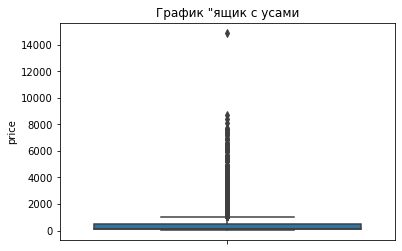

In [33]:
#строим ящик с усами для изучения данных в `price`

price = df_new['price']
sns.boxplot( y=price)

plt.title('График "ящик с усами')
plt.show()

Все значения положительные, нет 0 и отрицательных значений - уже хорошо. Мин цена 9 руб, макс 14 917 руб. На графике " ящик с усами" явно виден выброс в 14917 и единичные значения по цене выше 7000 руб. 

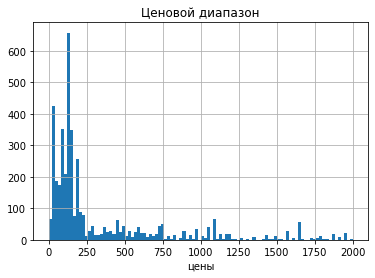

In [34]:
# построим гистограмму цены. 
#диапазон ограничим значением в 2 000 руб, после которого начинаются единичные значения
df_new['price'].hist(bins=100, range=(0,2000))
plt.title('Ценовой диапазон')
plt.xlabel('цены')
plt.show()

На данной гистограмме более наглядно видно, что диапазон цен, по которым чаще всего покупают товар находится в ценовом диапазоне от 10-250 руб, затем от 250- 750 руб. Все, что дороже, уже реже. 75% заказов находится в диапазоне 487 руб. Проверим,какие позиции стоят 2000 руб и больше.

In [35]:
# сделаем срез по границам цен
df_new.query('2000 < price< 15000').sort_values(by='price', ascending=False).head()

,date,customer_id,order_id,product,quantity,price,month,season_period,total,product_category
5992,2019-07-29,0d87f4ae-465a-4fac-81e6-5d629761783e,72139,сушилка уличная leifheit 85210 linomatic v 400 40 м 175х237х237 см зеленая,1,14917.0,7,лето,14917.0,растения
2697,2019-04-05,c0c60544-3a99-49d0-8a8e-cf7f293c22cb,71035,"сумка-тележка хозяйственная andersen royal shopper, hera, синяя 166-004-90",1,8737.0,4,весна,8737.0,порядок и хранение
1981,2019-02-24,ac250053-a236-467a-97d2-ddbb9bf4a1ba,70423,"сумка-тележка хозяйственная andersen alu star shopper, hava, синяя 115-103-90",1,8437.0,2,зима,8437.0,порядок и хранение
2997,2019-04-21,19d904d8-8d16-476d-8f66-b2a3b7a23660,71227,сумка-тележка хозяйственная rolser mnb019 rojo logic dos+2 красная,1,8077.0,4,весна,8077.0,порядок и хранение
6629,2019-10-16,d5584388-ffbe-42fd-a746-a98828ec919f,72992,стремянка 7 ступенчатая hailo 8040-707 xxl 13 см алюминиевая с лотком для инструментов,1,7724.0,10,осень,7724.0,строительсвто


В эту группу попали сумки_тележки, сушилки, полки, коврики, доски, самой дорогой позицей оказалась сушилка уличная
  Чуть ниже нам придется избавиться от выброса почти в 15 т руб.

In [36]:
# изучим данные в колонке `total` стоимость
df_new['total'].describe()

count      4357.000000
mean        864.153776
std       10366.031752
min           9.000000
25%         120.000000
50%         188.000000
75%         719.000000
max      675000.000000
Name: total, dtype: float64

In [37]:
# посчитаем перцентили кол-ва заказов
display('90, 95 и 99 перцентили количества заказов:', np.percentile(df_new['total'], [90, 95, 99]))

'90, 95 и 99 перцентили количества заказов:'

array([1662.8 , 2849.  , 6202.24])

  
Не более 5% покупателей покупают товара по стоимости дороже 2849 руб. и не более 1% дороже 6202 руб.



In [38]:
# посмотрим на уникальные значения `total` стоимость
display(df_new['total'].sort_values(ascending=False).head(10))

5456    675000.0
5071     49432.0
1518     47385.0
1299     32718.0
1023     29248.0
661      24370.0
1675     16536.0
2971     15680.0
3961     15300.0
5992     14917.0
Name: total, dtype: float64

   
75% стоимости находится в пределах 719 руб, есть единичные по 15 тыс и даже 675 000 руб. Удалим данные с стоимостью 675 000руб.,которая уйдет при коррекции кол-ва заказов




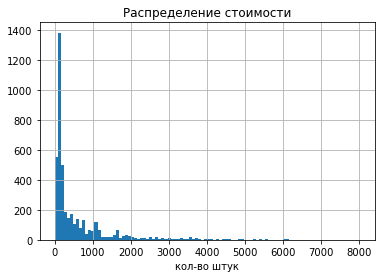

In [39]:
# построим гистограмму количества. 
#диапазон ограничим значением в пределах которого более наглядно можно увидеть распределение
df_new['total'].hist(bins=100, range=(0,8000))
plt.title('Распределение стоимости')
plt.xlabel('кол-во штук')
plt.show()

### Изучим кол-во позиций в заказе.

In [40]:
# выведем описание данных по кол-ву шт в позиции
df_new['quantity'].describe()

count    4357.000000
mean        2.770255
std        18.160044
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max      1000.000000
Name: quantity, dtype: float64

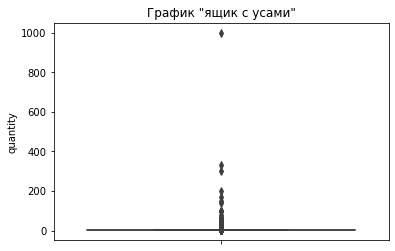

In [96]:
#строим ящик с усами для изучения данных в `quantity`

quantity = df_new['quantity']
sns.boxplot( y= quantity)

plt.title('График "ящик с усами"')
plt.show()

Здесь мы видим выбросы в 1000 шт и больше 150.

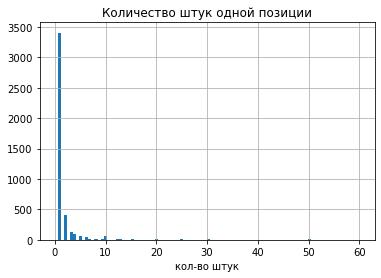

In [42]:
# построим гистограмму количества. 
#диапазон ограничим значением в пределах которого более наглядно можно увидеть распределение
df_new['quantity'].hist(bins=100, range=(0,60))
plt.title('Количество штук одной позиции')
plt.xlabel('кол-во штук')
plt.show()

В 75% случаев товар приобретают в 1 экземпляре.

In [43]:
# находим заказы с кол-м более 30 шт
df_new.query('quantity > 30').head()


,date,customer_id,order_id,product,quantity,price,month,season_period,total,product_category
568,2018-11-01,aa42dc38-780f-4b50-9a65-83b6fa64e766,68815,муляж яблоко 9 см красное,170,51.0,11,осень,8670.0,декор
586,2018-11-02,0c5aaa88-e346-4f87-8f7a-ad8cbc04e965,68831,муляж яблоко 9 см красное,140,59.0,11,осень,8260.0,декор
1023,2018-11-29,8fba3604-ef57-4b9f-b2fe-3402fa8825c8,69156,набор ножей attribute chef 5 предметов akf522,64,457.0,11,осень,29248.0,кухня
1103,2018-12-04,7d255526-fcc2-4f79-b28a-217d7d2373a8,69206,"щетка для посуды *оля*, мультипласт 1807010",100,26.0,12,зима,2600.0,кухня
1158,2018-12-10,a984c5b7-ff7e-4647-b84e-ef0b85a2762d,69289,"ручка-скоба рс-100 белая *трибатрон*, 1108035",200,29.0,12,зима,5800.0,строительсвто


В кол-ве шт в заказе нет 0 или отрицательных значений, мин знач 1 шт, что очень логично, и значит о, что магазин не продает по полпачки. В основном кол-во штук до 5, встречаются и 10, в бОльших кол-вах редкость. Кол-во вантузов в размере 1000 штук будем считать выбросом, слишком неправдоподобным это кажется, даже если это купил какой-то другой оптовый магазин... В противном случае это нам даст большой перекос и по стоимости и по кол-ву штук. Достаточно часто в больших кол-х встречаются муляжи яблок, но цвета разные, заказы в разные мес, поэтому остальное оставим.

In [44]:
# высчитаем перценили кол-ва заказов
display('90, 95 и 99 перцентили количества заказов:', np.percentile(df_new['quantity'], [90, 95, 99]))

'90, 95 и 99 перцентили количества заказов:'

array([ 3.,  7., 30.])

Не более 5% покупают в кол-ве 7 шт и не более 1% больше 30.

### Уберем выбивающиеся значения

In [45]:
# сделаем срез, убрав выбросы по макс цене и кол-ву шт в заказе И пользователю со 105 заказами.
df_final = df_new.query('total <= 50000 and customer_id !="c971fb21-d54c-4134-938f-16b62ee86d3b" and customer_id != "73d1cd35-5e5f-4629-8cf2-3fda829d4e58"')
df_final[['total','quantity']].describe()

,total,quantity
count,4222.000000,4222.000000
mean,695.757461,2.567977
std,1771.127010,10.222518
min,9.000000,1.000000
25%,120.000000,1.000000
50%,188.000000,1.000000
75%,686.000000,1.000000
max,49432.000000,334.000000


Почистили данные от выбросов по перцентилям, которые могли бы исказить наше исследование и по подсчету мы бы удалили 13% данных, поэтому ограничили по макс кол-ву шт 30 и по цене не дороже 8000 руб. 

In [46]:
#выведем общую информацию по очищенному датафрейму.

df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4222 entries, 567 to 6734
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              4222 non-null   datetime64[ns]
 1   customer_id       4222 non-null   object        
 2   order_id          4222 non-null   int64         
 3   product           4222 non-null   object        
 4   quantity          4222 non-null   int64         
 5   price             4222 non-null   float64       
 6   month             4222 non-null   int64         
 7   season_period     4222 non-null   object        
 8   total             4222 non-null   float64       
 9   product_category  4222 non-null   object        
dtypes: datetime64[ns](1), float64(2), int64(3), object(4)
memory usage: 362.8+ KB


In [47]:
# высчитаем кол-во удаленных значений
total_entries = df_updated['order_id'].count()
rest_entries = df_final['order_id'].count()
xx_entries = ((total_entries-rest_entries )/total_entries *100).round(2)
display(f' Доля удаленных данных {xx_entries}')

' Доля удаленных данных 12.77'

In [48]:
# посмотрим на уникальные значения в наших данных
display('Количество уникальных пользователей:{:.0f}'.format(df_final['customer_id'].nunique()))
display('Количество уникальных заказов:{:.0f}'.format(df_final['order_id'].nunique()))
display('Количество уникальных наименований товаров:{:.0f}'.format(df_final['product'].nunique()))


'Количество уникальных пользователей:2242'

'Количество уникальных заказов:2422'

'Количество уникальных наименований товаров:2057'

Убрать выбросы по перцетилям нам показалось неверным решением, так как теряли больше 10% данных,что неверно.

In [49]:
# изучим данные в `total`
df_final['total'].describe()

count     4222.000000
mean       695.757461
std       1771.127010
min          9.000000
25%        120.000000
50%        188.000000
75%        686.000000
max      49432.000000
Name: total, dtype: float64

In [50]:
# посмотрим еще раз на уникальные значения в total`
df_final['total'].sort_values(ascending=False)

5071    49432.0
1518    47385.0
1299    32718.0
1023    29248.0
661     24370.0
         ...   
6378       10.0
977        10.0
1078        9.0
5642        9.0
2159        9.0
Name: total, Length: 4222, dtype: float64

In [52]:
# выгрузки данных из таблицы df_final в файл df_final.csv
import os
path = str(os.getcwd())
df_final.to_csv(r"{}/df_final.csv".format(path), index=False, sep=";")

### Изучим продажи магазина на предмет сезонности. Посчитаем среднее и медиану.

In [53]:
# сгруппируем данные 
df_month = df_final.groupby(['month']).agg({'customer_id':'nunique','quantity':'median','price':'median','total':'median'}).reset_index()
df_month.rename(columns={'customer_id':'покупатель','price':'цена','total':'стоимость'},inplace=True)
df_month.head()

,month,покупатель,quantity,цена,стоимость
0,1,149,1.0,299.0,521.0
1,2,245,1.0,157.0,286.0
2,3,232,1.0,135.0,164.0
3,4,238,1.0,120.0,135.0
4,5,169,1.0,120.0,127.0


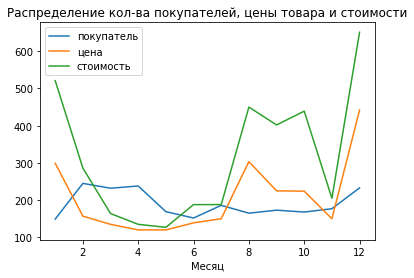

In [54]:
# построим график основных показателей по месяцам
df_month.plot(x='month', y=['покупатель','цена', 'стоимость'])
plt.xlabel("Месяц")
plt.title('Распределение кол-ва покупателей, цены товара и стоимости')
plt.show()

Количество уникальных покупателей росло в период с ноября по апрель, при этом средняя стоимость приобретаемого товара и цена также начали рост с ноября 18 года,средняя цена упала в феврале, стоимость в марте, апрель-май самые низкие показатели по стоимости и цене, 150 руб в среднем, стоимость начинает расти с к июню, а самый пик приходится на август, доходит до 480 руб по сравнению с 150 руб в мае. С июля по октябрь кол-во посетителей не увеличивается, тем неменее средняя цена и стоимость растет. причем стоимость больше, значит покупают по несколько штук в заказе.

### Сегментируем покупателей по категории продукции

In [55]:
# группируем данные по категории
df_cat = df_final.groupby('product_category').agg({'customer_id':'nunique', 'quantity':'median','price':'median','total':'median'}).\
               sort_values(by = 'total', ascending=False)
df_cat.rename(columns={'customer_id':'покупатель','price':'цена','total':'стоимость'},inplace=True)
df_cat

,покупатель,quantity,цена,стоимость
product_category,,,,
строительсвто,63,1.0,993.0,1424.0
порядок и хранение,678,1.0,749.0,1071.5
текстиль,186,1.0,750.0,974.0
кухня,197,1.0,223.0,508.0
ванна,41,1.0,299.0,404.0
декор,124,2.0,59.0,175.5
растения,1030,1.0,134.0,139.0


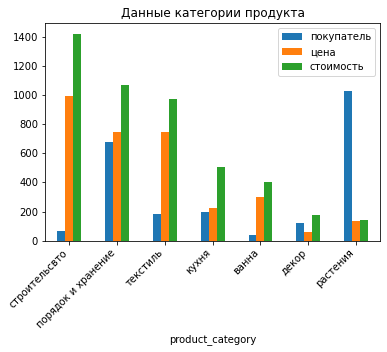

In [56]:
#количество покупателей, среднее цена и средний чек в продуктовой категории
df_cat.plot(y=['покупатель','цена','стоимость'],kind='bar')# строим сттолбчатую диаграмму
plt.title('Данные категории продукта')
plt.xticks(
    rotation=45,
    horizontalalignment='right',
    fontweight='light',
    fontsize='medium',
)
plt.show()

Категории с наибольшим средним чеком: строительство,порядок и хранение, текстиль. Причем лидерские позиции в строительствеза счет высокой стоимости товара, а не за счет большого кол-ва покупателей, в категории порядок и хранение - наоборот средняя цена ниже, но больше покупателей. Магазин очень популярен среди любителей растений и рассады, рекордное наибольшее кол-во уникальных покупателей 1024 были в данной категории, однако за счет низкой стоимости товара, средний чек здесь самый маленький в районе 139 руб,что почти в 10 раз меньше среднего чека в категории хранение и порядок, где средняя стоимость 1049 руб.

In [57]:
# группируем данные по категории продукта и сезону
df_cat_season = df_final.pivot_table(index = ['product_category'],columns = 'season_period', values = 'total',aggfunc = 'mean')
df_cat_season

season_period,весна,зима,лето,осень
product_category,,,,
ванна,531.200000,389.363636,1419.818182,305.818182
декор,655.395833,523.722222,424.304348,532.711864
кухня,788.000000,841.776471,549.700000,1178.279412
порядок и хранение,1824.690058,1750.807882,1770.887500,1550.058824
растения,225.313293,622.540984,417.182331,416.769430
строительсвто,1493.384615,1891.764706,2370.428571,1335.375000
текстиль,1914.558824,1315.984375,1320.232558,1305.050000


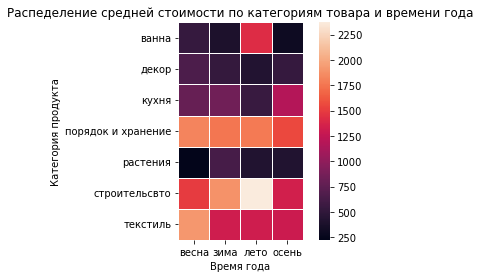

In [58]:
#построим тепловую карту, чтобы визуально увидеть распеделение средней стоимости по категориям товара и времени года

sns.heatmap(data = df_cat_season,linewidth=1, linecolor='w', square=True)
plt.title('Распеделение средней стоимости по категориям товара и времени года')
plt.ylabel('Категория продукта')
plt.xlabel('Время года')
plt.show()

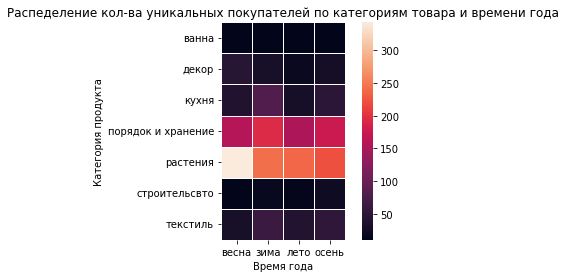

In [59]:
# построим тепловую карту, чтобы визуально увидеть распеделение кол-ва покупателей по категориям товара и времени года
df_cat_season1 = df_final.pivot_table(index = ['product_category'],columns = 'season_period',
                                      values = 'customer_id',aggfunc = 'nunique')
sns.heatmap(data = df_cat_season1,linewidth=1, linecolor='w', square=True)
plt.title('Распеделение кол-ва уникальных покупателей по категориям товара и времени года')
plt.ylabel('Категория продукта')
plt.xlabel('Время года')
plt.show()

По тепловй карте очень хорошо выделяется следующие закономерности:  
  **по средней стоимости**
1. категория `строительство` летом, где средняя стоимость более 2400 руб, `порядок и хранение` ровно популярен круглый год с слегка выраженным приоритетом весной 1250-1500 руб.
2. `декор`,`растения` находится в "черной зоне", от 220 руб и не превышает 750 руб, чуть лучше `кухня`от 250 до 1000    

**по количеству уникальных покупателей**  
  
1. лидируют `растения` весной, кол-во пукапателей более 300, второй популярной категорией является `порядок и хранения` в течение всего года, где количество покупателей от 150 до 200.  
2. Все остальные категории `кухня`,`декор`,`ванна`, `строительство`, `текстиль` не набирают и 100 уникальных покупателей.

### Сегментируем покупателей по количеству заказов.Выделение наиболее значимых групп. Визуализация данных. 

In [60]:
#группируем данные по покупателям
df_order = df_final.groupby('customer_id').agg({'order_id':'nunique'}).sort_values(by='order_id', ascending=False).reset_index()
df_order.head()


,customer_id,order_id
0,b7b865ab-0735-407f-8d0c-31f74d2806cc,7
1,0184f535-b60a-4914-a982-231e3f615206,5
2,498f12a4-6a62-4725-8516-cf5dc9ab8a3a,4
3,e0535076-6270-4df2-8621-cb06264a94fa,4
4,bea7a833-2074-42db-bc49-4457abd3c930,4


Сгруппировав наши данные по покупателям, мы посчитали кол-во уникальных заказов, которые сделал один покупатель  в течение года, расположив их в порядке убывания и видим, что есть один клиент, который сделал 105 заказов, очень хороший клиент, следующий клиент сделал уже 17 заказов, затем 7, 5 и тд, 105. Мы проверили заказы покупателя, возможно он как раз купил дачу и покурал от рассады до  посуды, сушилок и хоз сумок.

In [61]:
# посчитаем кол-во уникальных кол-в заказов
df_order['order_id'].value_counts()

1    2093
2     125
3      19
4       3
7       1
5       1
Name: order_id, dtype: int64

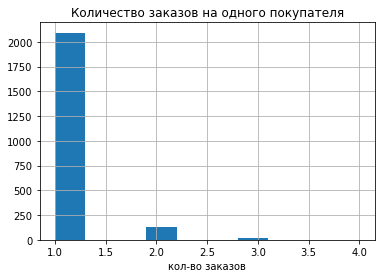

In [62]:
#построим гистограмму распределения кол-ва заказов
df_order['order_id'].hist(bins=10, range=(1,4))
plt.title('Количество заказов на одного покупателя')
plt.xlabel('кол-во заказов')
plt.show()

**Введем категории покупателей:**  
  А - кто сделал 1 покупку ( для нас это новые покупатели или те, кто совершил 1 покупку и не вернулся в течение года)  
  В - сделали 2 покупки  
  С - те кто, сделал более 2 заказов в год.

In [63]:
#присвоим категорию клиентам в зависимости от кол-ва заказов в анализируемый период
def order_category(order_id):
    if order_id == 1:
        return 'А'
    if order_id == 2:
        return 'B'
    return 'C'

In [64]:
# применим функцию к нашим данным
df_order['client_cat'] = df_order['order_id'].apply(order_category)
df_order = df_order.drop('order_id',axis=1)


# добавим категории в основной датафрейм
df_final = df_final.merge(df_order, on='customer_id')

In [65]:
#проверим добавился ли столбец и везде ли заполнен
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4222 entries, 0 to 4221
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              4222 non-null   datetime64[ns]
 1   customer_id       4222 non-null   object        
 2   order_id          4222 non-null   int64         
 3   product           4222 non-null   object        
 4   quantity          4222 non-null   int64         
 5   price             4222 non-null   float64       
 6   month             4222 non-null   int64         
 7   season_period     4222 non-null   object        
 8   total             4222 non-null   float64       
 9   product_category  4222 non-null   object        
 10  client_cat        4222 non-null   object        
dtypes: datetime64[ns](1), float64(2), int64(3), object(5)
memory usage: 395.8+ KB


Да, новый столбец появился , пропусков нет

In [66]:
# сгруппируем наши данные по категории клиента
df_order_pie = df_final.groupby('client_cat').agg({'customer_id':'nunique'})
df_order_pie

,customer_id
client_cat,
B,125
C,24
А,2093


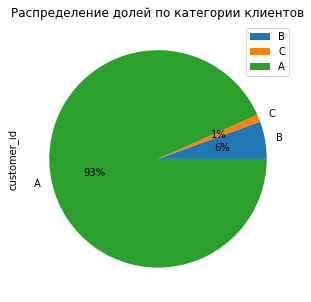

In [67]:
df_order_pie.plot(y='customer_id', kind= 'pie', figsize=(5,5),autopct='%1.0f%%')#построим круговую диаграмму 
plt.title('Распределение долей по категории клиентов')
plt.show()

93% покупателей сделали по одной покупке в год, лишь 6% вернулись еще раз и только 1% тех, кто сделал заказ более 2 раз. 

In [68]:
#сгруппируем данные по категории покупателя
df_order_grouped = df_final.groupby(['client_cat','season_period']).agg({'total':'mean'})
df_order_grouped

total
client_cat season_period             
B          весна           326.271930
           зима           1596.405797
           лето            934.473684
           осень           563.245902
C          весна           588.801527
           зима            140.800000
           лето            287.200000
           осень          1310.076923
А          весна           447.918269
           зима           1001.851032
           лето            792.072650
           осень           882.066396

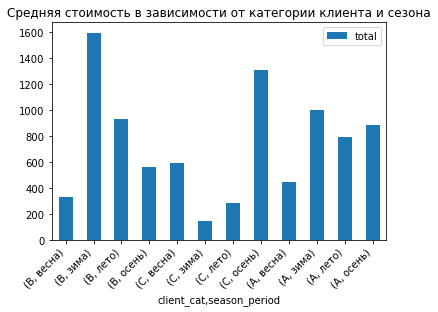

In [69]:
# средняя стоимость
df_order_grouped.plot(y=['total'],kind='bar')# строим сттолбчатую диаграмму
plt.title('Средняя стоимость в зависимости от категории клиента и сезона')
plt.xticks(
    rotation=45,
    horizontalalignment='right',
    fontweight='light',
    fontsize='medium',
)
plt.show()

Несмотря на обширную группу А (1 заказ) средняя стоимость от 700 до 850 руб, при этом оносительно ровные показатели по сравнению с другими категориями, где группа В зимой принесла в среднем почти 1600,а весной меньше 400 руб. Чуть меньше но в группе С тоже есть перепад с 250 летом до 1300 осенью.

### Сегментируем покупателей по среднему чеку. Выделение наиболее значимых групп. Визуализация данных.

In [70]:
#группируем данные по покупателю и высчитываем средний чек
df_avg_receipt = df_final.groupby(['customer_id']).agg({'total':'mean'}).round(2).sort_values(by='total', ascending=False)
df_avg_receipt.head()

,total
customer_id,
146cd9bf-a95c-4afb-915b-5f6684b17444,49432.0
6987e6d6-a63a-4ce2-a2d0-f424092d235e,32718.0
58a4c3cc-504f-43ea-a74a-bae19e665552,26616.0
1b2764ad-9151-4051-a46a-9b01b62e6335,24370.0
909564b8-3a5c-4d3e-8310-5ba1c837bbd7,16536.0


In [71]:
# выводим общую информацию
df_avg_receipt['total'].describe()

count     2242.000000
mean      1068.311191
std       2027.605224
min         14.000000
25%        172.357500
50%        524.000000
75%       1162.000000
max      49432.000000
Name: total, dtype: float64

У нас достаточно большой разброс в среднем чеке , мин сред чек 14 руб, макс 49432 руб

In [72]:
# на примере одного из клиентов посмотрим его заказы
df_final.query('customer_id == "58a4c3cc-504f-43ea-a74a-bae19e665552"')

,date,customer_id,order_id,product,quantity,price,month,season_period,total,product_category,client_cat
702,2019-01-10,58a4c3cc-504f-43ea-a74a-bae19e665552,69766,простынь вафельная 200х180 см wellness rw180-01 100% хлопок,3,1949.0,1,зима,5847.0,растения,B
703,2019-01-15,58a4c3cc-504f-43ea-a74a-bae19e665552,69830,простынь вафельная 200х180 см wellness rw180-01 100% хлопок,27,1755.0,1,зима,47385.0,растения,B


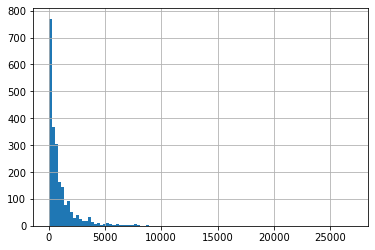

In [73]:
# строим гистограмму распределения среднего чека
df_avg_receipt['total'].hist(bins = 100, range=(0,27000))
plt.show()

In [74]:
#присвоим категорию клиентам в зависимости от кол-ва заказов в анализируемый период
def avr_receipt(total):
    if total <= 1000:
        return 'низкий'
    return 'высокий'

In [75]:
#применяем функцию
df_avg_receipt['avg_receipt'] = df_avg_receipt['total'].apply(avr_receipt)
df_avg_receipt.head()

,total,avg_receipt
customer_id,,
146cd9bf-a95c-4afb-915b-5f6684b17444,49432.0,высокий
6987e6d6-a63a-4ce2-a2d0-f424092d235e,32718.0,высокий
58a4c3cc-504f-43ea-a74a-bae19e665552,26616.0,высокий
1b2764ad-9151-4051-a46a-9b01b62e6335,24370.0,высокий
909564b8-3a5c-4d3e-8310-5ba1c837bbd7,16536.0,высокий


In [76]:
#добавим новые категории в наш основной датафрейм
df_avg_receipt = df_avg_receipt.drop('total',axis=1)


# добавим категории в основной датафрейм
df_final = df_final.merge(df_avg_receipt, on='customer_id')

#выведим общую инорфмацию
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4222 entries, 0 to 4221
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              4222 non-null   datetime64[ns]
 1   customer_id       4222 non-null   object        
 2   order_id          4222 non-null   int64         
 3   product           4222 non-null   object        
 4   quantity          4222 non-null   int64         
 5   price             4222 non-null   float64       
 6   month             4222 non-null   int64         
 7   season_period     4222 non-null   object        
 8   total             4222 non-null   float64       
 9   product_category  4222 non-null   object        
 10  client_cat        4222 non-null   object        
 11  avg_receipt       4222 non-null   object        
dtypes: datetime64[ns](1), float64(2), int64(3), object(6)
memory usage: 428.8+ KB


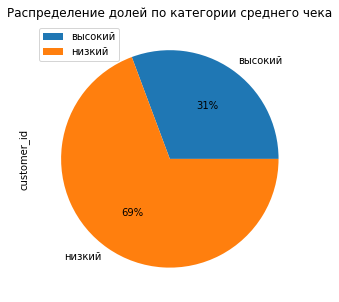

In [77]:
# строим круговую диаграмму по категории среднего чека
df_avg_pie = df_final.groupby('avg_receipt').agg({'customer_id':'nunique'})

df_avg_pie.plot(y='customer_id', kind= 'pie', figsize=(5,5),autopct='%1.0f%%')#построим круговую диаграмму 
plt.title('Распределение долей по категории среднего чека')
plt.show()


Мы расчитали средний чек по клиенту, изучили общую ситуацию по магазину, где разброс показателей от 14 руб до 26 т. руб, 75% покупателей в среднем приносит магазину 1097 руб, средний чек по магазину 979 руб. Разделим наших покупателей на 2 группы с низким и высоким средним чеком. Все,у кого чек менее 1000 руб, попали в категорию `низкий` , остальные в `высокий`.В результате у нас получилось 1555 покупателей с низким чеком, это 69% всех покупателей и 659  с высоким. Добавили эту категоризацию в основной датафрейм.

### Сегментируем по кол-ву позиций в заказе. Определение опт или розница. Визуализация данных

In [78]:
#изучим в каком кол-ве заказывают клиенты магазина
df_quantity = df_final.groupby('order_id').agg({'quantity':'sum'}).sort_values(by='quantity', ascending=False)
df_quantity.head()

,quantity
order_id,
71668,334
71478,300
69289,200
68815,170
70841,150


In [79]:
# изучим общую картину по кол-ву
df_quantity['quantity'].describe()

count    2422.000000
mean        4.476466
std        14.013007
min         1.000000
25%         1.000000
50%         1.000000
75%         3.000000
max       334.000000
Name: quantity, dtype: float64

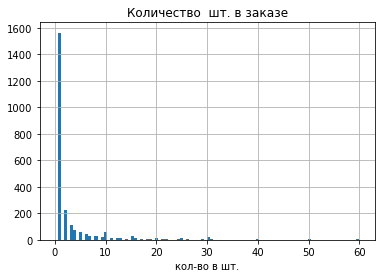

In [80]:
#построим гистограмму по кол-ву штук в заказе
df_quantity['quantity'].hist(bins=100, range=(0,60))
plt.title('Количество  шт. в заказе')
plt.xlabel('кол-во в шт.')
plt.show()

В 75% заказов заказыват товар в кол-ве 2 шт, мин 1, максимальное кол-во шт. есть даже 60, в таких огромных кол-я закупают плечики, ручки-скобы, муляжи яблок.

0 - розница
1 - опт

In [82]:
#присвоим категорию клиентам в зависимости от кол-ва позиций в заказе (опт/розница)
def quantity_cat(quantity):
    if quantity <= 10:
        return 'розница'
    return 'опт'

In [83]:
# применим функцию к нашему датафрейму, сгруппированному по кол-ву заказов
df_quantity['quantity_cat'] = df_quantity['quantity'].apply(quantity_cat)

# проверим работу функции
df_quantity['quantity_cat'].unique()



array(['опт', 'розница'], dtype=object)

In [84]:
# удалим столбец с кол-в, чтобы впоследствии добавить категории к основному датафрейму
df_quantity = df_quantity.drop('quantity',axis=1)


# дабим категорию кол-ва в основную таблицу
df_final = df_final.merge(df_quantity, on ='order_id')
df_final.head()

,date,customer_id,order_id,product,quantity,price,month,season_period,total,product_category,client_cat,avg_receipt,quantity_cat
0,2018-11-01,c9279020-09f8-461e-a694-4937485620d5,68816,тележка багажная delta тбр-20 синий грузоподъемность 25 кг сумка и 50 кг каркас россия,1,742.0,11,осень,742.0,порядок и хранение,А,низкий,розница
1,2018-11-01,aa42dc38-780f-4b50-9a65-83b6fa64e766,68815,муляж яблоко 9 см красное,170,51.0,11,осень,8670.0,декор,А,высокий,опт
2,2018-11-01,499ee08a-43b5-4f2c-a3fc-96d04f5cbb11,68821,"гладильная доска ника бэлль 106,5х29 см б",1,524.0,11,осень,524.0,порядок и хранение,А,низкий,розница
3,2018-11-01,499ee08a-43b5-4f2c-a3fc-96d04f5cbb11,68821,подрукавник складной ника п,1,224.0,11,осень,224.0,порядок и хранение,А,низкий,розница
4,2018-11-01,fb9704c7-8106-4e7a-a2a4-70a97550deb4,68822,"муляж ""райские яблочки зеленые"" 2 шт полиуретан, d 3 см",1,29.0,11,осень,29.0,растения,А,низкий,опт


In [85]:
# сгруппируем данные
df_final.groupby('quantity_cat').agg({'order_id':'nunique'})


,order_id
quantity_cat,
опт,211
розница,2211


Основываясь на данных кол-ва штук по позиции мы разбили покупателей не тех, кто покупает маленькими объемами и тех, кто 
большими, присвоили категории: `опт`и `розница`. В 2211 заказах кол-во штук в позиции не превышает 10 шт.

### Кластеризация покупателей. Составление профилей кластера.

In [86]:
#группируем наши данные по пользователю для кластеризации
df_grouped = df_final.groupby('customer_id').agg({'order_id':'nunique', 'quantity':'mean','price':'mean','total':'mean'}).round(2).reset_index()
df_grouped.head()


,customer_id,order_id,quantity,price,total
0,000d6849-084e-4d9f-ac03-37174eaf60c4,1,1.0,138.75,138.75
1,001cee7f-0b29-4716-b202-0042213ab038,1,1.0,442.00,442.00
2,00299f34-5385-4d13-9aea-c80b81658e1b,1,2.0,457.00,914.00
3,002d4d3a-4a59-406b-86ec-c3314357e498,1,1.0,1649.00,1649.00
4,003bbd39-0000-41ff-b7f9-2ddaec152037,1,2.0,1162.00,2324.00


In [87]:
# удаляем номер покупателя из дата сета
X= df_grouped.drop('customer_id', axis = 1)


In [88]:
# стандартизируем данные
sc = StandardScaler()
X_sc = sc.fit_transform(X)

In [89]:
linked = linkage(X_sc, method = 'ward')

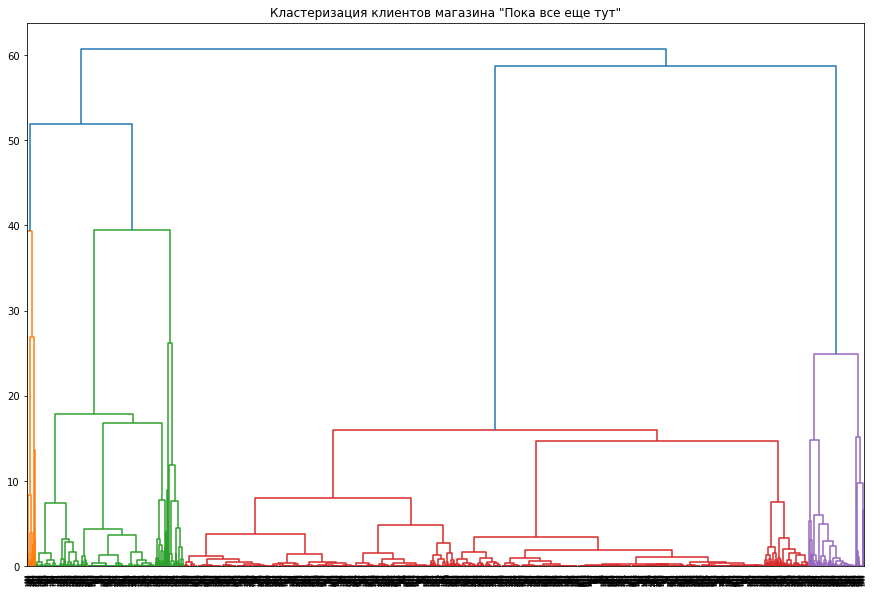

In [90]:
plt.figure(figsize = (15,10))
dendrogram (linked, orientation = 'top')
plt.title ('Кластеризация клиентов магазина "Пока все еще тут"')
plt.show()

In [91]:
# обучим модель на основании алгоритма KMeans
km = KMeans(n_clusters = 4, random_state = 0)

# спрогнозируем кластеры для наблюдений
labels = km.fit_predict(X_sc)

In [92]:
# сохраним метки кластера в поле нашего датасета
df_grouped['cluster_km'] = labels
df_grouped.head()


,customer_id,order_id,quantity,price,total,cluster_km
0,000d6849-084e-4d9f-ac03-37174eaf60c4,1,1.0,138.75,138.75,0
1,001cee7f-0b29-4716-b202-0042213ab038,1,1.0,442.00,442.00,0
2,00299f34-5385-4d13-9aea-c80b81658e1b,1,2.0,457.00,914.00,0
3,002d4d3a-4a59-406b-86ec-c3314357e498,1,1.0,1649.00,1649.00,0
4,003bbd39-0000-41ff-b7f9-2ddaec152037,1,2.0,1162.00,2324.00,0


In [93]:
# посмотрим на средние значения по кластерам
clusters = round(df_grouped.groupby(['cluster_km']).mean().reset_index(),2)
clusters1 = clusters.T
clusters1


,0,1,2,3
cluster_km,0.00,1.00,2.00,3.00
order_id,1.00,1.00,1.04,2.23
quantity,2.72,159.18,1.62,2.77
price,503.89,95.91,3860.10,452.89
total,699.73,12316.36,4518.00,644.42


In [94]:
# посмотрим как распределились данные в кластерах
df_grouped['cluster_km'].value_counts()

0    1905
2     185
3     141
1      11
Name: cluster_km, dtype: int64

 У нас сформировалось 4 кластера, самый большой на 1905 пользователя, два кластера близких по кол-ву покупателей (196 и 118), 4й отдельный кластер с одним покупателем.  
  **Описание кластеров:**    
  **0 кластер:** у нас 1905 покупателя. Средняя стоимость приобретаемой продукции 699 руб, среднее кол-во единиц в заказе 2.72 шт., средняя цена 504 руб. - `средний`
   
  **1 кластер:** сюда попал 11 покупателей, среднее кол-во ед-ц продукции 159 шт., средняя стоимость приобретаемой продукции 96 руб, в среднем по цене 12316 руб. -  `самый доходный оптовик` 
  
  **2 кластер:** 185 уникальных пользователя, кол-во заказов 1.04, как и в 0 и 1 кластерах,  среднее кол-во единиц в заказе1.62 шт, по средней цене 3860, при этом средняя стоимость 4518 руб - `мало, но по высокой цене`.  

  **3 кластер:** 141 уникальных покупателя, кол-во заказов 2.23 и кол-во единиц 2.77, однако средняя цена 453 ,а стоимость 644.42 - `средний`.
   

In [97]:
df_grouped = df_grouped[['customer_id','cluster_km']]

# добавляем кластеризацию в основной датафрейм
df_clustered = df_final.merge(df_grouped, on = 'customer_id')
df_clustered.head()

,date,customer_id,order_id,product,quantity,price,month,season_period,total,product_category,client_cat,avg_receipt,quantity_cat,cluster_km
0,2018-11-01,c9279020-09f8-461e-a694-4937485620d5,68816,тележка багажная delta тбр-20 синий грузоподъемность 25 кг сумка и 50 кг каркас россия,1,742.0,11,осень,742.0,порядок и хранение,А,низкий,розница,0
1,2018-11-01,aa42dc38-780f-4b50-9a65-83b6fa64e766,68815,муляж яблоко 9 см красное,170,51.0,11,осень,8670.0,декор,А,высокий,опт,1
2,2018-11-01,499ee08a-43b5-4f2c-a3fc-96d04f5cbb11,68821,"гладильная доска ника бэлль 106,5х29 см б",1,524.0,11,осень,524.0,порядок и хранение,А,низкий,розница,0
3,2018-11-01,499ee08a-43b5-4f2c-a3fc-96d04f5cbb11,68821,подрукавник складной ника п,1,224.0,11,осень,224.0,порядок и хранение,А,низкий,розница,0
4,2018-11-01,fb9704c7-8106-4e7a-a2a4-70a97550deb4,68822,"муляж ""райские яблочки зеленые"" 2 шт полиуретан, d 3 см",1,29.0,11,осень,29.0,растения,А,низкий,опт,0


In [98]:
# выводим общую информацию по датафрейму
df_clustered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4222 entries, 0 to 4221
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              4222 non-null   datetime64[ns]
 1   customer_id       4222 non-null   object        
 2   order_id          4222 non-null   int64         
 3   product           4222 non-null   object        
 4   quantity          4222 non-null   int64         
 5   price             4222 non-null   float64       
 6   month             4222 non-null   int64         
 7   season_period     4222 non-null   object        
 8   total             4222 non-null   float64       
 9   product_category  4222 non-null   object        
 10  client_cat        4222 non-null   object        
 11  avg_receipt       4222 non-null   object        
 12  quantity_cat      4222 non-null   object        
 13  cluster_km        4222 non-null   int32         
dtypes: datetime64[ns](1), fl

### Характеристики сегмента с учетом сезонности

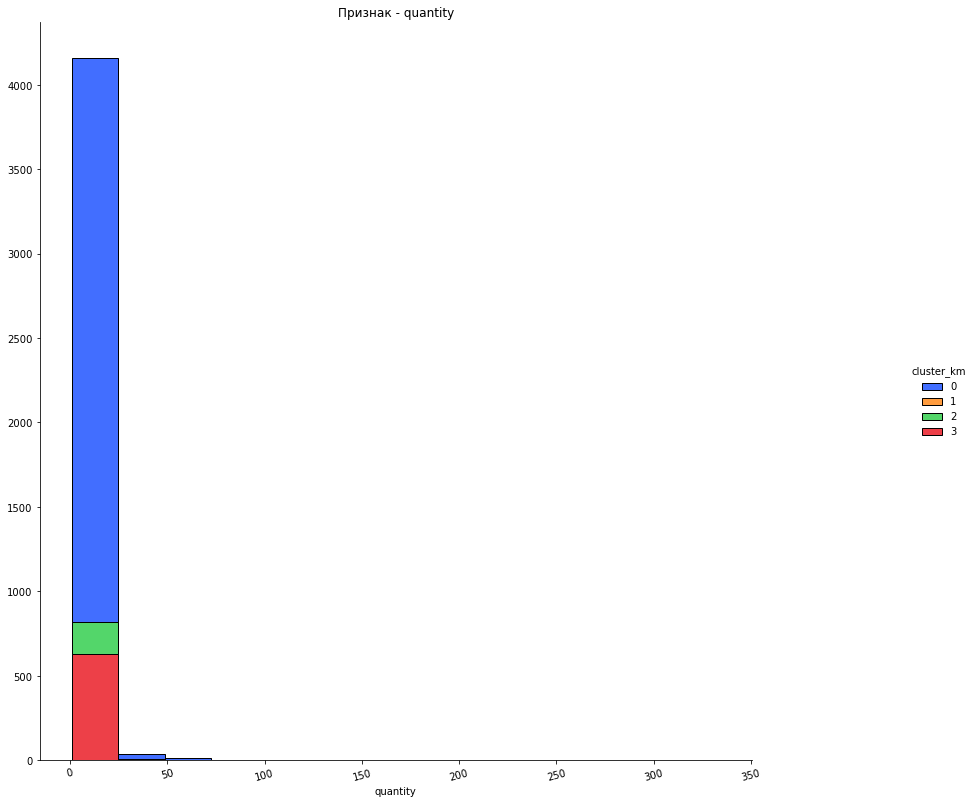

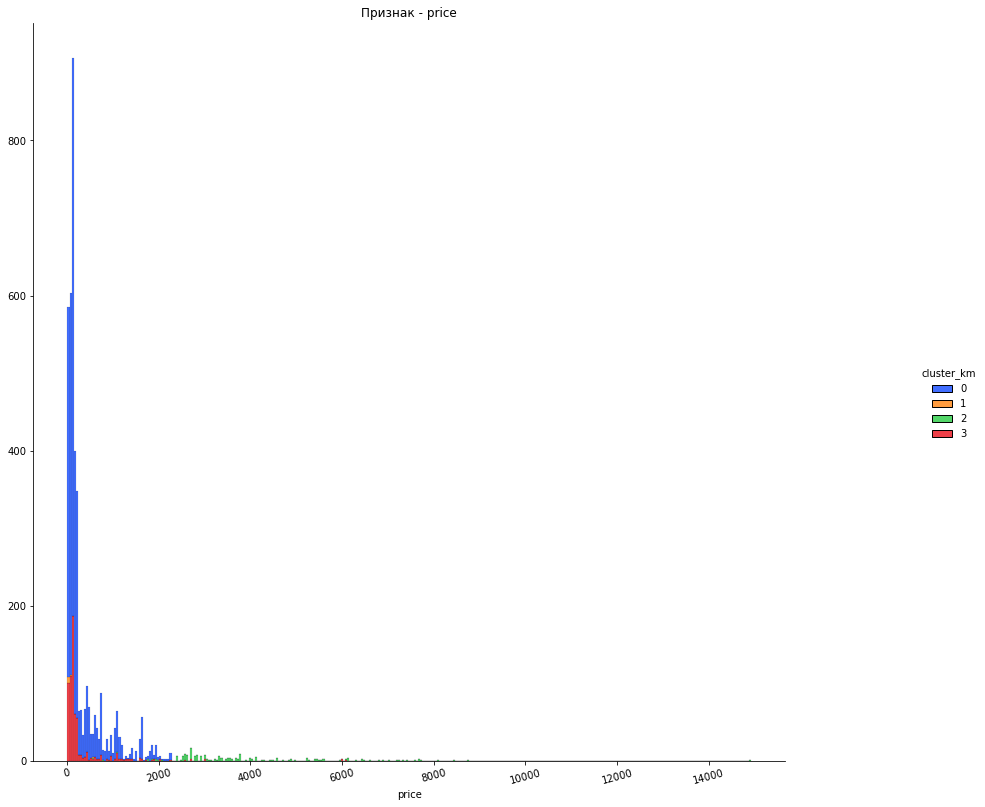

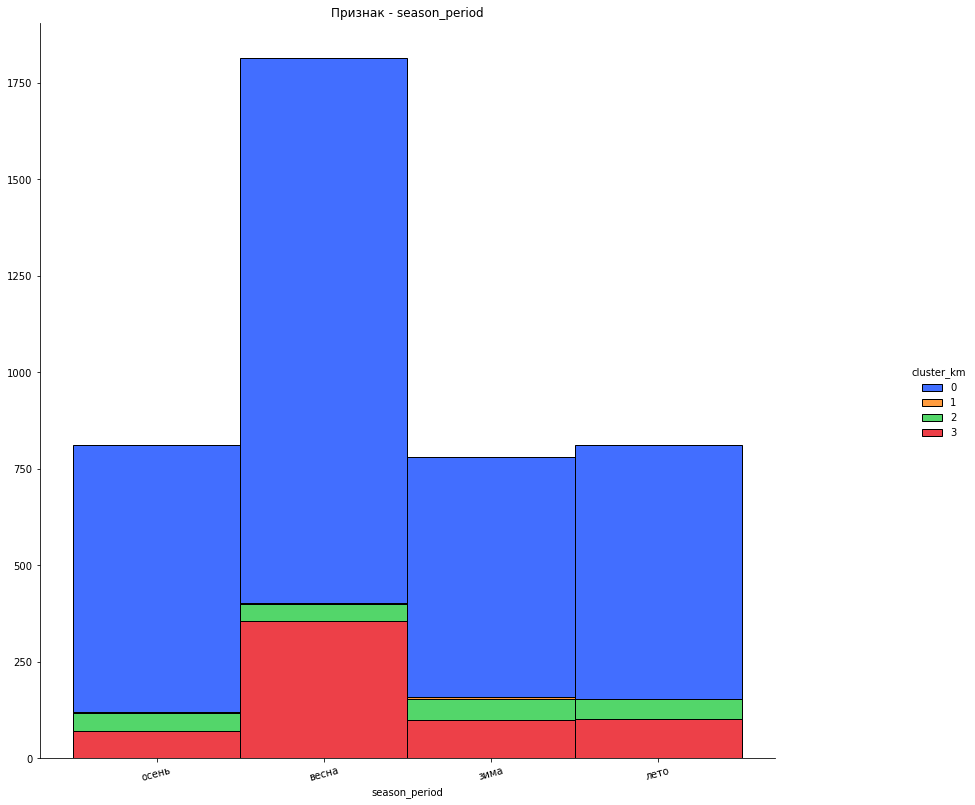

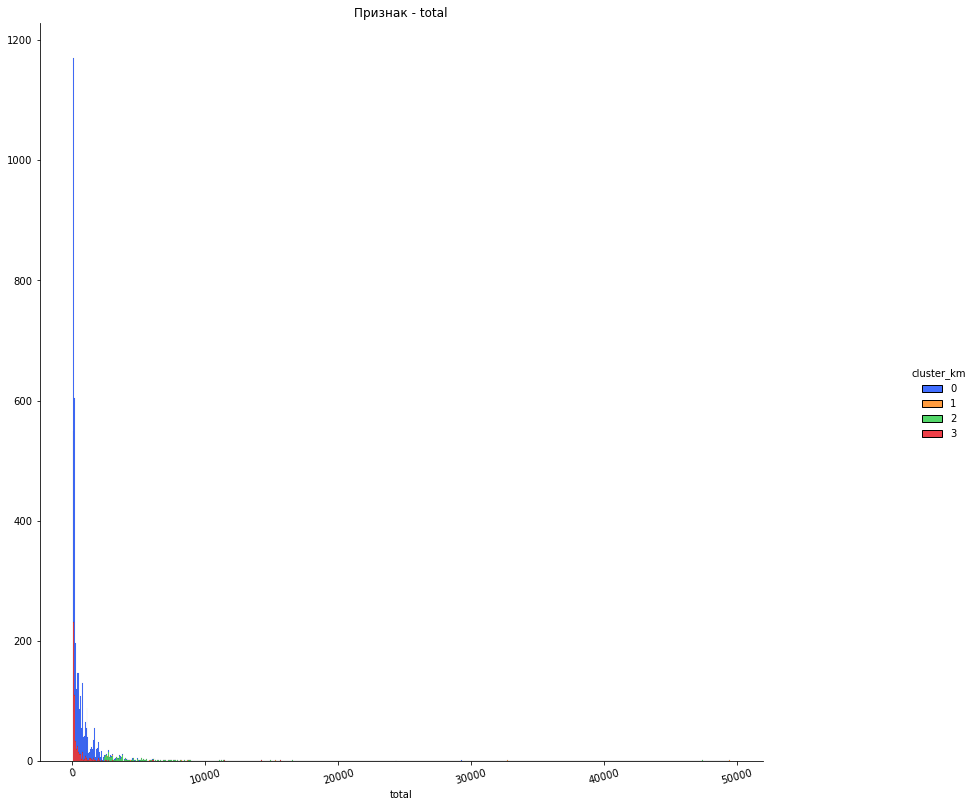

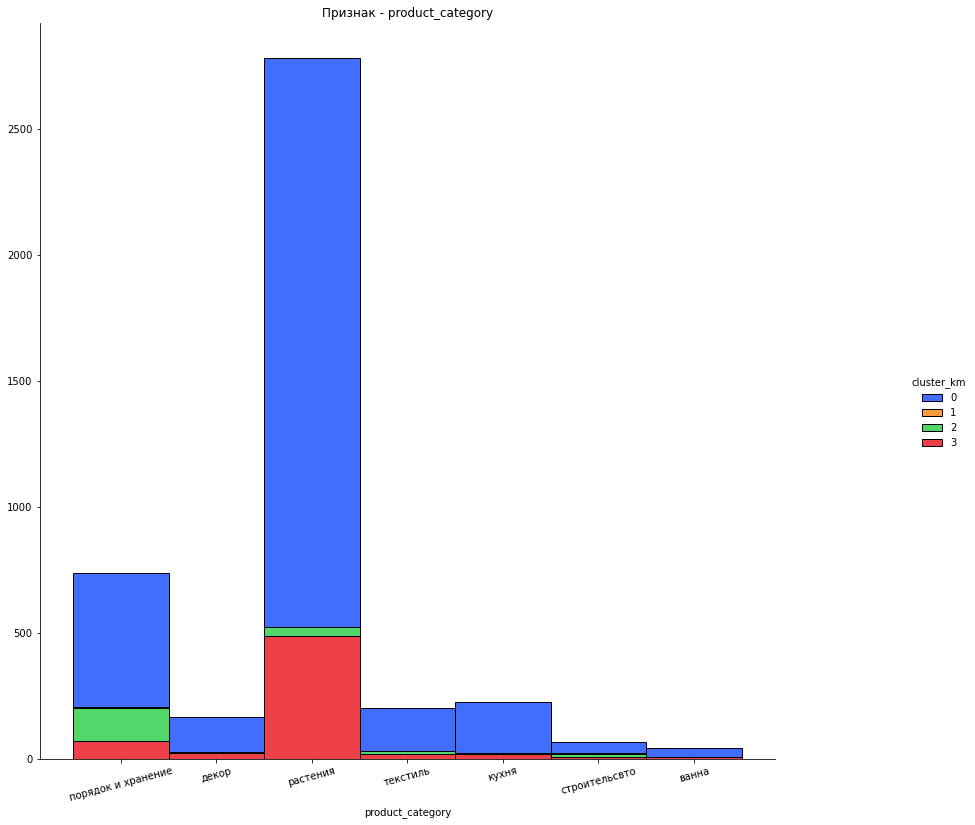

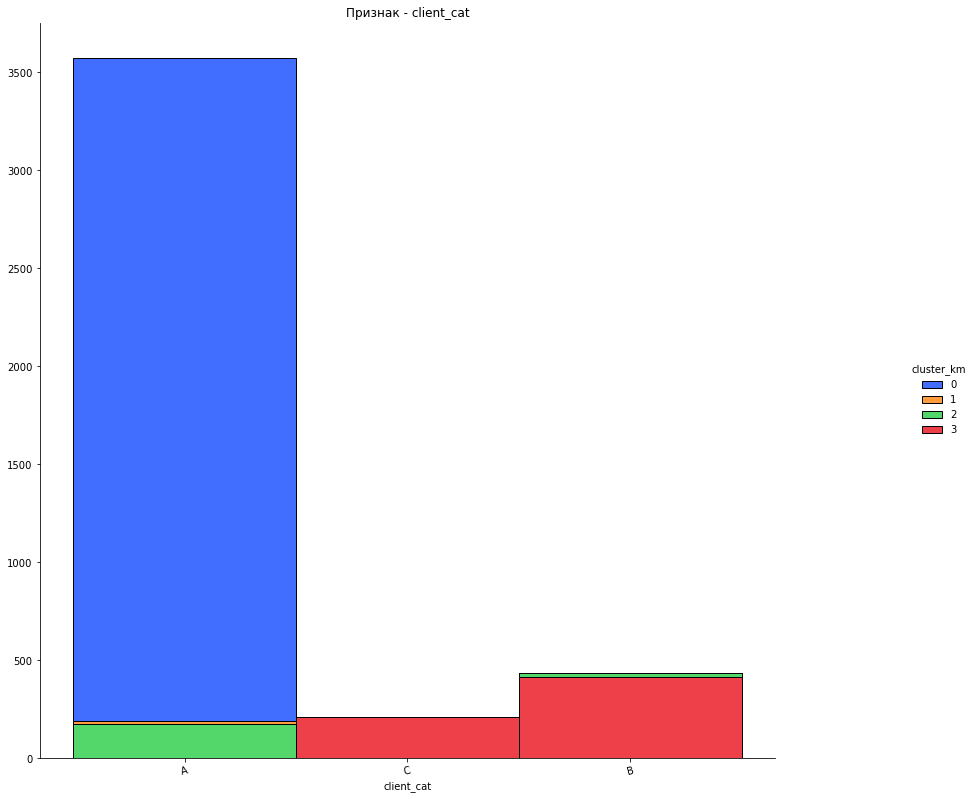

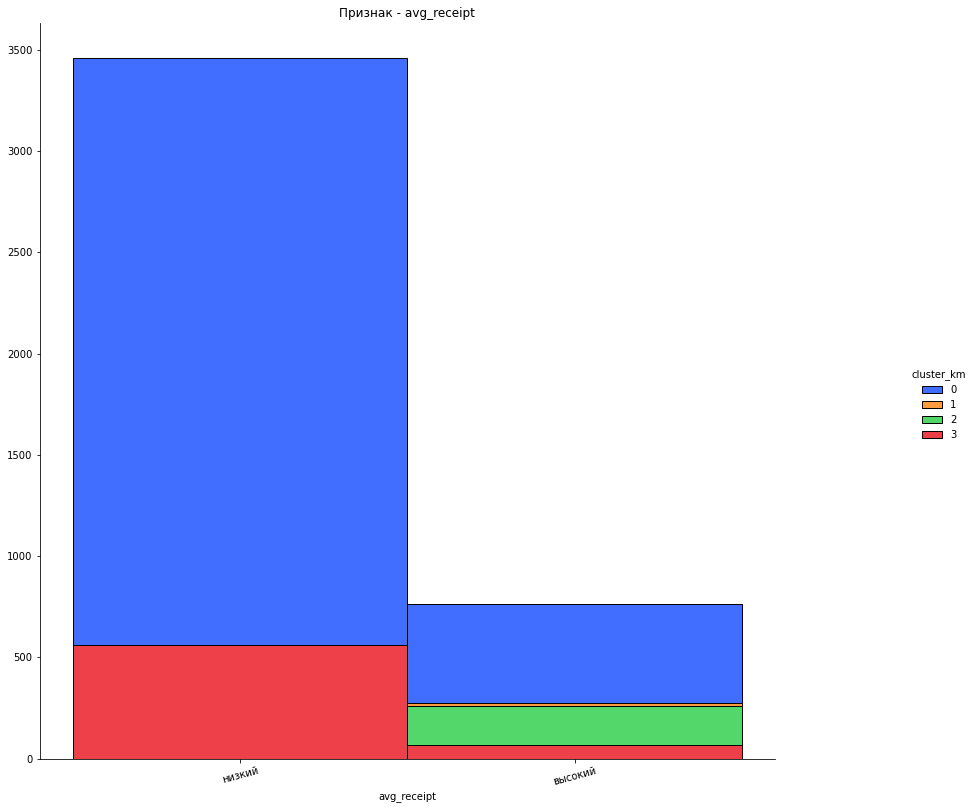

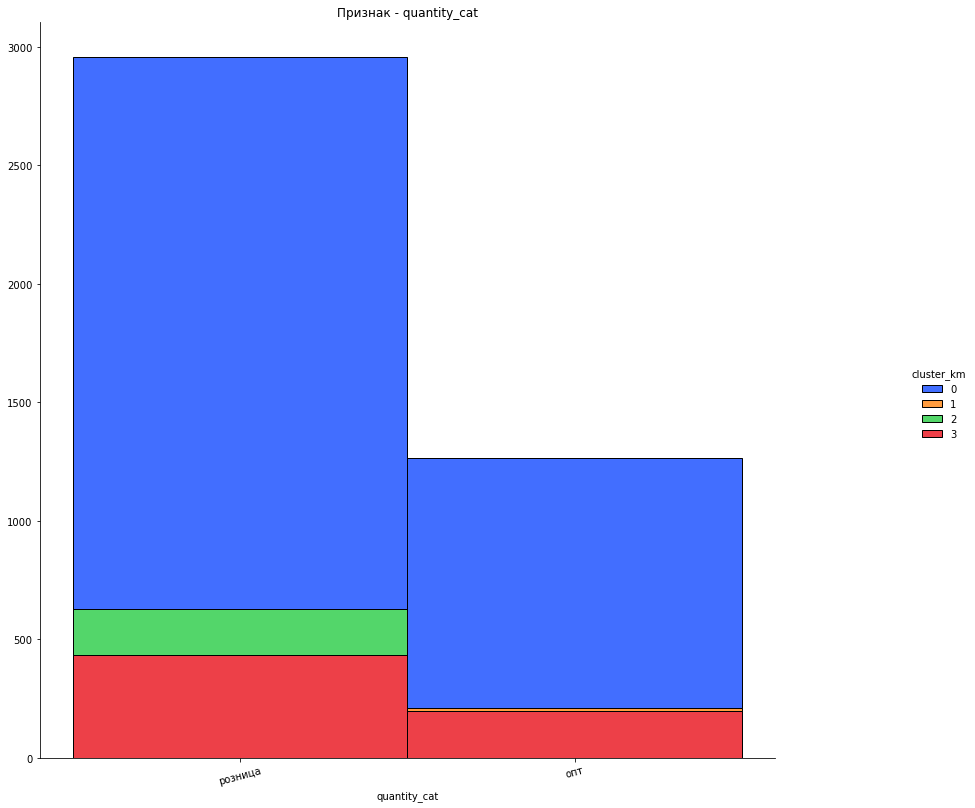

In [99]:
# строим распределение принаков по кластерам
for i in df_clustered.drop(['cluster_km','date','customer_id','product','order_id','month'],axis=1).columns:
    ax = sns.displot(df_clustered,x=df_clustered[i], hue ='cluster_km', multiple = 'stack', palette = "bright")
   
   
    plt.title(f'Признак - {i}')
    plt.xlabel(f'{i}')
    plt.ylabel("")
    
    
    ax.fig.set_figwidth(15)
    ax.fig.set_figheight(12)
    plt.xticks(rotation = 15) 
    plt.show()

### Выводы  
  Для детального анализа продаж магазина "Пока все ещё тут" мы ввели категории продукции, разделили всех пользователей на группы по кол-ву заказов в год, по среднему чеку, по кол-ву единиц в заказе, изучили эти данные в разрезе сезонности.  
  Ситуация получается следующая, что по каждому столбцу мы проверили данные на аномальность, по возможности убрали выбросы по кол-ву заказов, кол-ву штук в заказе, стоимости. В определении диапазонов выбросов мы руководствовались процентилями и так, чтобы сохранить 90% данных. 
  Провели кластеризацию, машина предложила 4 кластера, в отдельный кластер был выделен один покупатель с общим кол-м заказов 105, по сравнению со всеми остальными покупателями такое кол-во заказов никак не сравнимо. Однако относить к выбросам такого клиента мы не стали.  
  
 
    
Все кластеры,кроме 1го активны круглый год с общей более выраженной активностью весной, 1 кластер только зимой. В 3 и 0 кластер попали покупатели с более низким средним чеком на покупателя, менее 1000руб, однако с более дорогим ср чеком попали во все кластеры. Кластер номер 1 выделился своиви оптовыми участниками, 2й - розничными, в остальных кластерах представлены оба типа 

  

## Постановка и проверка гипотез

### Гипотеза №1

У нас есть два кластера, мы хотим проверить, действительно ли средние чеки этих кластеров статистически отличаются.Для этого у нас имеются две выборки среднего чека по каждому кластеру, сравним их при помощи ttest. Н0 - средняя выручка двух кластеров равны. Н1 - средние не равны

In [100]:
df_clustered.groupby('cluster_km')[['total']].agg({'median','var','std'}).style.format('{:.0f}')

In [101]:
def mannwhitneyu (group1, group2):
    
    alpha = .01
    
    results = st.mannwhitneyu(group1, group2)
        
    

    
    print('p-значение:', results.pvalue)
    if results.pvalue<alpha:
        print("Отвергаем нулевую гипотезу")
    else:
        print("Не получилось отвергнуть нулевую гипотезу")

In [102]:
mannwhitneyu(df_clustered[df_clustered['cluster_km'] == 1]['total'].dropna(),
                       df_clustered[df_clustered['cluster_km'] == 2]['total'].dropna())

p-значение: 0.08411988249727459
Не получилось отвергнуть нулевую гипотезу


In [103]:
mannwhitneyu(df_clustered[df_clustered['cluster_km'] == 0]['total'].dropna(),
                       df_clustered[df_clustered['cluster_km'] == 1]['total'].dropna())

p-значение: 1.593728419498905e-08
Отвергаем нулевую гипотезу


In [104]:
mannwhitneyu(df_clustered[df_clustered['cluster_km'] == 0]['total'].dropna(),
                       df_clustered[df_clustered['cluster_km'] == 2]['total'].dropna())

p-значение: 4.9663431155847735e-118
Отвергаем нулевую гипотезу


In [105]:
mannwhitneyu(df_clustered[df_clustered['cluster_km'] == 0]['total'].dropna(),
                       df_clustered[df_clustered['cluster_km'] == 3]['total'].dropna())

p-значение: 9.909200319847544e-05
Отвергаем нулевую гипотезу


In [106]:
mannwhitneyu(df_clustered[df_clustered['cluster_km'] == 1]['total'].dropna(),
                       df_clustered[df_clustered['cluster_km'] == 3]['total'].dropna())

p-значение: 2.278562630161425e-08
Отвергаем нулевую гипотезу


In [107]:
mannwhitneyu(df_clustered[df_clustered['cluster_km'] == 2]['total'].dropna(),
                       df_clustered[df_clustered['cluster_km'] == 3]['total'].dropna())

p-значение: 9.24960941994125e-95
Отвергаем нулевую гипотезу


### Заключение по 1й гипотезе
 При проверке средних чеков с помощью теста mannwhitneyu мы убедились что кластеризация прошла удачно во всех случаях, кроме 1 и 2 кластера, где отвергнуть нулевую гипотезу не получилось, а именно с вероятностью 8% средний стоимости в этих двух кластерах могут оказаться равными. 


### Гипотеза №2.

Проверим еще одну гипотезу: отличается ли среднее кол-во единиц товара в заказе между кластерами 0 и 1.   
  Н0 - среднее кол-во в выборках равно. Н1 - среднее кол-во единиц тоавра отличается.

In [108]:

df_clustered.groupby('cluster_km')[['quantity']].agg({'median','var','std'}).style.format('{:.0f}')

In [109]:
def mannwhitneyu (group1, group2):
    
    alpha = .01
    
    results = st.mannwhitneyu(group1, group2)
        
    

    
    print('p-значение:', results.pvalue)
    if results.pvalue<alpha:
        print("Отвергаем нулевую гипотезу")
    else:
        print("Не получилось отвергнуть нулевую гипотезу")

In [110]:
mannwhitneyu(df_clustered[df_clustered['cluster_km'] == 0]['quantity'].dropna(),
                       df_clustered[df_clustered['cluster_km'] == 1]['quantity'].dropna())

p-значение: 3.270545075117458e-15
Отвергаем нулевую гипотезу


In [111]:
mannwhitneyu(df_clustered[df_clustered['cluster_km'] == 0]['quantity'].dropna(),
                       df_clustered[df_clustered['cluster_km'] == 2]['quantity'].dropna())

p-значение: 4.1441877864098693e-05
Отвергаем нулевую гипотезу


In [112]:
mannwhitneyu(df_clustered[df_clustered['cluster_km'] == 0]['quantity'].dropna(),
                       df_clustered[df_clustered['cluster_km'] == 3]['quantity'].dropna())

p-значение: 0.1449724850808893
Не получилось отвергнуть нулевую гипотезу


In [113]:
mannwhitneyu(df_clustered[df_clustered['cluster_km'] == 1]['quantity'].dropna(),
                       df_clustered[df_clustered['cluster_km'] == 2]['quantity'].dropna())

p-значение: 3.7121655270367254e-20
Отвергаем нулевую гипотезу


In [114]:
mannwhitneyu(df_clustered[df_clustered['cluster_km'] == 1]['quantity'].dropna(),
                       df_clustered[df_clustered['cluster_km'] == 3]['quantity'].dropna())

p-значение: 1.0786699756903318e-13
Отвергаем нулевую гипотезу


In [115]:
mannwhitneyu(df_clustered[df_clustered['cluster_km'] == 2]['quantity'].dropna(),
                       df_clustered[df_clustered['cluster_km'] == 3]['quantity'].dropna())

p-значение: 9.731598469945502e-06
Отвергаем нулевую гипотезу


### Заключение по 2й гипотезе

После проведения теста mannwhitneyu для сравнения среднего кол-ва единиц товара в заказе мы заметили, что в большинтсве случаев ср кол-во отличается, однако между 2и 3 с вероятностью 97% слйчайно может кол-во совпасть , а межд 0 и 3  средние равны, однако с вероятностью 14% может возникнуть ситуация отличия среднего кол-ва.  

## Выводы

In [118]:
# сгруппируем наши idпользвателей по кластерам
report=df_clustered.groupby('cluster_km').agg({'customer_id':'unique'})


За изученный период с 01.11.2018- 31.10.2019 у магазина имеются 2242 уникальных покупателя, было сделано 2422 заказа и продано 2057 уникальных наименований товаров.

Наибольшее количество покупателей наблюдается в продуктовой категории - `растения` ( 1030 покупателей), следующая популярная категория  - `порядок и хранение`, 678 уникальных покупателя.

По стоимости приобретаемой продукции выделяется `строительство`, где средняя стоимость 1424, средняя же стоимость популярной категории `растения`не превышает 139 руб.

93% всех покупателей сделали лишь 1 покупку за год, 6% вернулись и сделали вторую покупку.

69% покупателей с средним чеком меньше 1000 руб.

Сезонность по покупателям наблюдается с февраля по апрель, в среднем 250 уникальных покупателей, 150-190 в остальные мес, был небольшой подъем в декабре, за 200 покупателей.
По стоимости был рост в декабре до марта 19, средняя стоимость более 600 руб, затем спад до 140 руб и рост в июле до ноября, до макс значений 450 руб.

Исходя из выше изученного было выделено  и сформировано 4 кластера покупателей.

По средней цене и стоимости они разделены фактически на тех, кто покупает товары по более низкой или наоборот по высокой цене. И в зависимости от этого меняется приоритет продуктовых товаров: в более дорогой попало `строительство`,  в другой `растения`, которые имеют особенность низкой цены и большего количества покупок.

У нас сформировалось 4 кластера, самый большой на 1905 пользователя, два кластера близких по кол-ву покупателей (196 и 118), 4й отдельный кластер с 11 покупателями.  

**Описание кластеров:**

**0 кластер:** у нас 1905 покупателя. Средняя стоимость приобретаемой продукции 699 руб, среднее кол-во единиц в заказе 2.72 шт., средняя цена 504 руб. Данный кластер активен круглый год, наиболее выраженный сезон - весна. Приоритетная продуктовая категория - растения, порядок и хранение, но покупают и во всех категориях, здесь только те, кто сделал одну покупку, по типу среднего чека на пользователя в основном меньше 1000, но есть и выше.  

**1 кластер:** сюда попал 11 покупателей, среднее кол-во ед-ц продукции 159 шт., средняя цена приобретаемой продукции 96 руб, в среднем по стоимости 12316 руб. Достаточно маленький кластер, активничал осенью, весной и чуть более заметно летом по немногу во всех продуктовых категориях

**2 кластер:** 185 уникальных пользователя, кол-во заказов 1.04, среднее кол-во единиц в заказе 1.62 шт, по средней цене 3860, при этом средняя стоимость 4518 руб . Активен круглый год, популярные категории: порядок и хранение, растения, текстиль и строительство, в основном пукапатели, сделавшие 1 покупку и совсем немного тех, кто больше 2х, средний чек выше 1000 руб и только розничные покупки, т есть в кол-ве до 10 шт.

**3 кластер:** 141 уникальных покупателя, кол-во заказов 2.23 и кол-во единиц 2.77, однако средняя цена 453 ,а стоимость 644.42. Круглогодичные покупки, наиболее активны весной, популярная категория - растения, затем порядок и хранение, в других категориях так же случаются покупки, покупатели с 2мя и более заказами, по кол-ву единиц товара: больше менее 10, но есть и те, кто больше.


Рекомендации:
Однозначно этот магазин популярен среди любителей цветов, рассады и вообще растений, поэтому рассылку следует:
 - настроить по сезону, учитывая актуальность тех или иных растений, 
 - так же включать в рассылку рекламу сопутствующих товаров из всего ассортимента.
 - ввести программу лояльности и поощрительной системой за повторную покупку


Цель работы была - выявление профилей потребления.

Проанализировав предоставленные данные были выделены 4 профиля потребителя и выгружены списки уникальных пользователей.

